In [115]:
# from google.colab import drive
# drive.mount('/content/drive')

import xgboost as xgb
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# !pip install gower

from sklearn import linear_model
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_absolute_error, mean_squared_error

from sklearn.ensemble import RandomForestRegressor

from sklearn import preprocessing

In [116]:
FOLDER_PATH = r'/content/drive/MyDrive/ML_Project_Data/'

In [117]:
import os

os.listdir(FOLDER_PATH)

['train.csv', 'test.csv', 'submit_lr.csv', 'submit_xgb.csv', 'solution.csv']

In [118]:
train_file = pd.read_csv(FOLDER_PATH + r"train.csv")
test_file = pd.read_csv(FOLDER_PATH  + r"test.csv")

In [119]:
object_type_columns = [x for x in train_file.columns if train_file.dtypes[x] == 'object']
object_type_columns

['Product_ID', 'Gender', 'Age', 'City_Category', 'Stay_In_Current_City_Years']

In [120]:
num_type_columns = [x for x in train_file.columns if train_file.dtypes[x] != 'object']
num_type_columns

['User_ID',
 'Occupation',
 'Marital_Status',
 'Product_Category_1',
 'Product_Category_2',
 'Product_Category_3',
 'Purchase']

In [121]:
train_file.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [122]:

train_file.describe(include='all')

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
count,5.500680e+05,550068,550068,550068,550068.000000,550068,550068,550068.000000,550068.000000,376430.000000,166821.000000,550068.000000
unique,NaN,3631,2,7,NaN,3,5,NaN,NaN,NaN,NaN,NaN
top,NaN,P00265242,M,26-35,NaN,B,1,NaN,NaN,NaN,NaN,NaN
freq,NaN,1880,414259,219587,NaN,231173,193821,NaN,NaN,NaN,NaN,NaN
mean,1.003029e+06,NaN,NaN,NaN,8.076707,NaN,NaN,0.409653,5.404270,9.842329,12.668243,9263.968713
std,1.727592e+03,NaN,NaN,NaN,6.522660,NaN,NaN,0.491770,3.936211,5.086590,4.125338,5023.065394
min,1.000001e+06,NaN,NaN,NaN,0.000000,NaN,NaN,0.000000,1.000000,2.000000,3.000000,12.000000
25%,1.001516e+06,NaN,NaN,NaN,2.000000,NaN,NaN,0.000000,1.000000,5.000000,9.000000,5823.000000
50%,1.003077e+06,NaN,NaN,NaN,7.000000,NaN,NaN,0.000000,5.000000,9.000000,14.000000,8047.000000
75%,1.004478e+06,NaN,NaN,NaN,14.000000,NaN,NaN,1.000000,8.000000,15.000000,16.000000,12054.000000


We can say that:
- Male made most of transactions
- The majority of people came from city B
- People whose age group is 26-35 took the lead in buying products

In [123]:
missing_values= train_file.isnull().sum()
percent_missing = train_file.isnull().sum()/train_file.shape[0]*100

value = {
    'no_missing_values':missing_values,
    'percent_missing':percent_missing
}
frame=pd.DataFrame(value)
frame

,no_missing_values,percent_missing
User_ID,0,0.000000
Product_ID,0,0.000000
Gender,0,0.000000
Age,0,0.000000
Occupation,0,0.000000
City_Category,0,0.000000
Stay_In_Current_City_Years,0,0.000000
Marital_Status,0,0.000000
Product_Category_1,0,0.000000
Product_Category_2,173638,31.566643


In [124]:
price = train_file.groupby(["Product_Category_1", "Product_Category_2", "Product_Category_3"]).agg(avg_price=('Purchase', 'mean')).reset_index()
price

,Product_Category_1,Product_Category_2,Product_Category_3,avg_price
0,1,2.0,3.0,13939.696574
1,1,2.0,4.0,8184.129771
2,1,2.0,5.0,13954.539589
3,1,2.0,6.0,12502.539501
4,1,2.0,8.0,14910.815000
...,...,...,...,...
132,11,15.0,16.0,4135.394118
133,12,14.0,17.0,1269.094340
134,13,14.0,16.0,683.608863
135,13,15.0,16.0,673.448790


([<matplotlib.lines.Line2D at 0x7fe8c2e47850>],
 [<matplotlib.lines.Line2D at 0x7fe8c2e47fd0>])

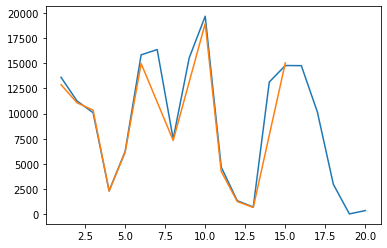

In [125]:
price1 = price.groupby(["Product_Category_1"]).agg(avg_price_1=('avg_price', 'mean')).reset_index()

price_product1 = train_file.groupby(["Product_Category_1"]).agg(avg_price=('Purchase', 'mean')).reset_index()

plt.plot(price_product1.Product_Category_1, price_product1.avg_price.values), plt.plot(price1.Product_Category_1, price1.avg_price_1.values)

([<matplotlib.lines.Line2D at 0x7fe8c3200890>],
 [<matplotlib.lines.Line2D at 0x7fe8c31f5090>])

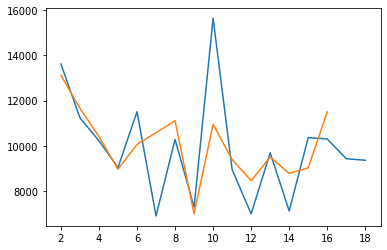

In [126]:
price2 = price.groupby(["Product_Category_2"]).agg(avg_price_2=('avg_price', 'mean')).reset_index()

price_product2 = train_file.groupby(["Product_Category_2"]).agg(avg_price=('Purchase', 'mean')).reset_index()
plt.plot(price_product2.Product_Category_2, price_product2.avg_price.values), plt.plot(price2.Product_Category_2, price2.avg_price_2.values)

([<matplotlib.lines.Line2D at 0x7fe8c2081490>],
 [<matplotlib.lines.Line2D at 0x7fe8c2081c50>])

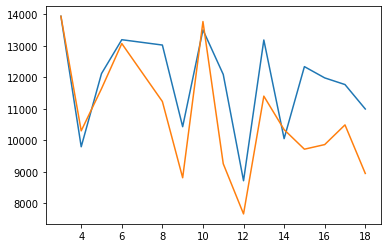

In [127]:
price3 = price.groupby(["Product_Category_3"]).agg(avg_price_3=('avg_price', 'mean')).reset_index()

price_product3 = train_file.groupby(["Product_Category_3"]).agg(avg_price=('Purchase', 'mean')).reset_index()
plt.plot(price_product3.Product_Category_3, price_product3.avg_price.values), plt.plot(price3.Product_Category_3, price3.avg_price_3.values)

In [128]:
# train = train_file.loc[:, ~train_file.columns.isin(['User_ID', 'Product_ID'])]
# test = test_file.loc[:, ~test_file.columns.isin(['User_ID', 'Product_ID'])]

# checkpoint = train.shape[0]

train_file.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [129]:
# # fill null value of categories with 0
train_file['Product_Category_2'].fillna(0, inplace=True)
train_file['Product_Category_3'].fillna(0, inplace=True)

# # convert all product category to int
# data['Product_Category_2'] = data['Product_Category_2'].apply(np.int64)
# data['Product_Category_3'] = data['Product_Category_3'].apply(np.int64)



In [130]:
  train = train_file.copy()
  test = test_file.copy()
  

In [131]:
train.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,0.0,0.0,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,0.0,0.0,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,0.0,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,0.0,0.0,7969


In [132]:
# train = train.loc[:, ~train.columns.isin(['Product_Category_1', 'Product_Category_2', 'Product_Category_3', 'Purchase'])]
train.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,0.0,0.0,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,0.0,0.0,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,0.0,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,0.0,0.0,7969


In [133]:
# train = pd.get_dummies(train, columns=['Gender',	'Age', 	'Occupation', 'City_Category',	'Stay_In_Current_City_Years',	'Marital_Status'])
train.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,0.0,0.0,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,0.0,0.0,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,0.0,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,0.0,0.0,7969


In [134]:
import random

def partition (list_in, n):
    random.shuffle(list_in)
    return [list_in[i::n] for i in range(n)]

k = partition (list(range(3000)), 511)
df_user.iloc[k[0]], k[0]

(         Occupation  Marital_Status  Gender_F  Gender_M  Age_0-17  Age_18-25  \
 User_ID                                                                        
 1001086           4               0         0         1         0          1   
 1001649          19               1         0         1         0          1   
 1002672           7               1         0         1         0          0   
 1000548          16               1         1         0         0          0   
 1001471          17               0         0         1         0          0   
 1001268           2               1         0         1         0          0   
 
          Age_26-35  Age_36-45  Age_46-50  Age_51-55  Age_55+  City_Category_A  \
 User_ID                                                                         
 1001086          0          0          0          0        0                1   
 1001649          0          0          0          0        0                0   
 1002672          0   

In [135]:
import random
import math

def partition (list_in, n):
    random.shuffle(list_in)
    return [list_in[i::n] for i in range(n)]

class recommendation_system:
  def __init__(self):
    self.train = train
    self.test = test

    self.price = self.train.groupby(['Product_Category_1']).Purchase.agg(['min', 'max'])
    self.price['range'] = self.price['max'] - self.price['min']
    

  def processing_train(self, data):
    data['rating'] = 5*(data['Purchase'] - data['Purchase'].min())/(data['Purchase'].max() - data['Purchase'].min())

    # hash user id
    user_id_dict = {}
    for idx, val in enumerate(list(data.User_ID.unique())):
      user_id_dict[val] = idx

    # hash product id
    product_id_dict = {}
    for idx, val in enumerate(list(data.Product_ID.unique())):
      product_id_dict[val] = idx

    # generate rating and status matrices
    rating = np.zeros((len(user_id_dict), len(product_id_dict)))
    status = np.zeros((len(user_id_dict), len(product_id_dict)))

    # set rating and status values
    for idx, row in data.iterrows():
      u = user_id_dict[row['User_ID']]
      p = product_id_dict[row['Product_ID']]

      rating[u, p] = row.rating
      status[u, p] = 1

    df_rating = pd.DataFrame(rating, columns = list(product_id_dict.keys()), index = list(user_id_dict.keys()))

    df_status = pd.DataFrame(status, columns = list(product_id_dict.keys()), index = list(user_id_dict.keys()))

    user_attribute = data.groupby(['User_ID', 'Gender',	'Age', 	'Occupation', 'City_Category',	'Stay_In_Current_City_Years',	'Marital_Status']).groups.keys()
    df_user = pd.DataFrame(user_attribute, columns = ['User_ID', 'Gender',	'Age', 	'Occupation', 'City_Category',	'Stay_In_Current_City_Years',	'Marital_Status']).sort_values(by=['User_ID'])
    df_user = df_user.set_index('User_ID')
    df_user = pd.get_dummies(df_user)


    df_product = pd.DataFrame(np.random.rand(rating.shape[1], df_user.shape[1]), columns = list(df_user.columns), index = list(product_id_dict.keys()))

    self.n_u = df_rating.shape[0]
    self.n_p = df_rating.shape[1]

    return df_user, df_product, df_rating, df_status, user_id_dict, product_id_dict


  def costfunction(self, X, y, r, theta, Lambda):
    predictions = np.dot(X, theta.T)* r
    err = predictions-y
    J = 1/2 * np.sum(np.sum((err**2) ))
    reg_x = Lambda/2 * np.sum(np.sum(theta**2))
    reg_theta = Lambda/2 * np.sum(np.sum(X**2))
    return J + reg_x + reg_theta


  def sgd(self, X, y, r, theta, batch_size, Lambda, num_iter, alpha):
    n_batch = int(self.n_u/batch_size)
    J_hist = []
    for i in range(num_iter):
      batch = partition (list(range(self.n_u)), n_batch)

      for i in range(len(batch)):

        temp_X = X.iloc[batch[i]]
        temp_Y = y.iloc[batch[i]]
        temp_r = r.iloc[batch[i]]


        cost = self.costfunction(temp_X, temp_Y, temp_r, theta, Lambda)
        theta = theta - alpha*(np.dot((np.dot(temp_X, theta.T)*temp_r - temp_Y).T, temp_X) + Lambda*theta) 
        J_hist.append(cost)
        print(cost)
    return theta, J_hist


  def normalizeRatings(self, y, r):
    ymean = np.sum(y, axis=1)/np.sum(r, axis=1)
    ynorm = np.sum(y, axis=1)*np.sum(r, axis=1) - ymean
    return ymean, ynorm
  
  def fit(self):
    train_data, test_data = train_test_split(self.train, test_size =.30, random_state=10)

    # we will combine all the data into 1 dataset, however we will not provide the purchase of the rows that will be used for evaluating like validation set or test set
    # therefore the status value of corresponding user and product will be 0. Hence, the cost function will not be affected
    # validation
    copy_validation_set = test_data.copy()
    copy_validation_set.Purchase = np.nan
    # test
    copy_test_set = self.test.copy()
    copy_test_set.Purchase = np.nan

    # train_data = pd.concat([train_data, copy_validation_set, copy_test_set])

    df_train_user, df_train_product, df_train_rating, df_train_status, user_dict, product_dict = self.processing_train(self.train)
    # df_test_user, df_test_product, df_test_rating, df_test_status = self.processing_train(test_data)

    lr = [0.00001, 0.00003]
    hist = []
    for ilr in lr:
      theta, J_hist = self.sgd(df_train_user, df_train_rating, df_train_status, df_train_product,500, 10, 20, ilr)
      hist.append(J_hist)

    self.theta = theta

    return hist

  def getProduct(self):
    return self.theta

  def predict(self, test):
    mean = pd.DataFrame(self.theta.describe().loc['mean'])

    if 'Purchase' not in test.columns:
      test['Purchase'] = np.nan

    df_test_user, df_test_product, df_test_rating, df_test_status, user_dict, product_dict  = rs.processing_train(test)

    # set all new product attribute equal to mean
    idx = list(mean.index)

    for i in range(len(idx)):
      df_test_product[idx[i]] = mean.iloc[[i], [0]].values[0, 0]


    similarity_idx = df_test_product.index.intersection(self.theta.index)

    df_test_product.loc[similarity_idx] = self.theta.loc[similarity_idx]

    self.theta = self.theta.append(df_test_product.loc[df_test_product.index.difference(self.theta.index)])

    result = np.dot(df_test_user, df_test_product.T)* df_test_status
    result.columns = list(product_dict)

    result = pd.DataFrame(result, index=list(user_dict))

    test.predict = np.nan

    for i, r in test.iterrows():
      test.at[i , 'predict'] = result.loc[[r.User_ID], [r.Product_ID]].values[0, 0] * self.price.loc[[r.Product_Category_1]].values[0, 2] /5 + self.price.loc[[r.Product_Category_1]].values[0, 0]

    return test
  

In [136]:
rs = recommendation_system()


1329441.4215044335
1353612.0235732428
1248357.0968020665
1167076.810815625
1036025.3607370228
1054598.939265829
1086825.694105519
1005571.3601484935
1043986.0169378875
880618.1750985687
994670.2340663827
887007.039525447
943642.0119047876
886941.4198952718
728124.0693836263
755767.9202930168
735948.7086773084
854969.6834772236
748728.1597612244
839676.1559103194
740105.0415755342
711746.2034338306
728620.3619898023
729326.5679984761
719251.0883125144
667490.2285134627
674756.8567809802
681699.2169418205
659230.0192962324
623571.1066075279
628174.2250497818
713251.877871132
627297.871535353
604998.5884769371
660059.9510578911
592327.4693188138
627969.0922318492
608527.0752460106
615394.9395333616
589065.942777245
550068.0018674142
627009.7198432576
610455.6145905536
621867.8266997575
528548.6130744376
573340.5503281872
582077.0427191867
618409.5013668089
550408.2415151249
564188.1783779217
579585.7237630654
547088.895371571
569918.4995407439
579171.2231133608
552103.1338142338
575501.58

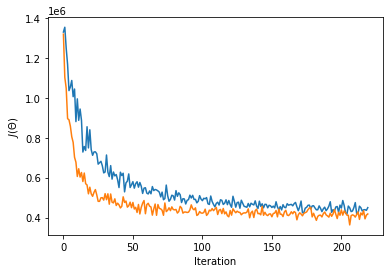

In [137]:
hist = rs.fit()

plt.figure()
plt.xlabel("Iteration")
plt.ylabel("$J(\Theta)$")

for lr in hist:
  plt.plot(lr)

In [138]:
submit = rs.predict(test)


In [ ]:
submit = submit[['User_ID', 'Product_ID', 'predict']]

submit = submit.rename(columns = {'predict': 'Purchase'})

In [142]:
submit.to_csv(FOLDER_PATH + 'solution.csv')